In [9]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 15))
train_y = Variable(torch.sign(torch.cos(train_x.data * (2 * math.pi))))

In [11]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [12]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-3,3))
        self.register_parameter('log_lengthscale', nn.Parameter(torch.Tensor([0])), bounds=(-3,3))
    
    
    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x, log_lengthscale=self.log_lengthscale)
        covar_x = covar_x.mul(self.log_outputscale.exp().expand_as(covar_x))
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_model = GPClassificationModel()

In [13]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

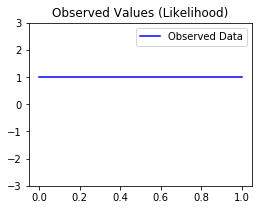

In [14]:
f = plot_model_and_predictions(prior_model, plot_train_data=False)

In [16]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.01)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = posterior_model.forward(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.log_lengthscale.data[0],
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()
None

Iter 1/20 - Loss: nan   log_lengthscale: 0.000
Iter 2/20 - Loss: nan   log_lengthscale: -0.010


RuntimeError: Lapack Error syev : 14 off-diagonal elements didn't converge to zero at /opt/conda/conda-bld/pytorch_1502001039157/work/torch/lib/TH/generic/THTensorLapack.c:384

In [ ]:
f = plot_model_and_predictions(posterior_model)

In [ ]:
%debug

> /home/jrg365/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py(735)_input_request()
    733             except KeyboardInterrupt:
    734                 # re-raise KeyboardInterrupt, to truncate traceback
--> 735                 raise KeyboardInterrupt
    736             else:
    737                 break

